In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvid

In [2]:
from datasets import load_dataset
import datasets

ds = load_dataset("roneneldan/TinyStories")

README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Tokenize the dataset 
1. into tokenids
2. file train.bin and validation.bin  where we we store tokenids from entire dataset
3. token ids store on disk rather than on the ram for efficient computations

we will   use byte pair encoding (gpt 2 subword tokenisation)(subwords tokenisation has all words characters an d subwords)

In [3]:
!pip install tiktoken 
import tiktoken 
import os
import numpy as np
from tqdm.auto import tqdm

enc= tiktoken.get_encoding("gpt2")

def process(example):
    ids=enc.encode_ordinary(example['text'])
    out={'ids':ids,'len':len(ids)}
    return out

if not os.path.exists("train.bin"):
     tokenized=ds.map(
         process,
         remove_columns=['text'],
         desc="tokenizing the splits",
         num_proc=8,
         )
     for split,dset in tokenized.items():
         arr_len=np.sum(dset['len'], dtype=np.uint64)
         filename=f"{split}.bin"
         dtype=np.uint16 
         arr=np.memmap(filename,dtype=dtype,mode='w+',shape=(arr_len,))
         total_batches=1024
         idx=0
         for batch_idx in tqdm(range(total_batches), desc=f'writing{filename}'):
             batch=dset.shard(num_shards=total_batches,index=batch_idx,contiguous=True).with_format('numpy')
             arr_batch=np.concatenate(batch['ids'])
             arr[idx: idx+len(arr_batch)]=arr_batch
             idx+=len(arr_batch)
     arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writingtrain.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writingvalidation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Create Input Output batches for the dataset

In [4]:
def get_batch(split):
    if(split=='train'):
        data=np.memmap('train.bin', dtype=np.uint16 , mode='r')
    else:
        data=np.memmap('validation.bin', dtype=np.uint16 , mode='r')
    ix=torch.randint(len(data)- block_size, (batch_size,))
    x=torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y=torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type=='cuda':
        x , y=x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x,y=x.to(device), y.to(device)
    return x,y

Define the SLM Model Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [6]:
config = GPTConfig(
    vocab_size=50257,     # tokenizer's vocab size
    block_size=128,     
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

In [7]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [8]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 
max_iters = 30000 
warmup_steps = 1000 
min_lr = 5e-4 
eval_iters = 500 
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32 

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [9]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

scaler = torch.amp.GradScaler('cuda',enabled=(dtype == 'float16'))

In [10]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# model is on the correct device
model = model.to(device)

# training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/30000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 9.3444, val loss 9.3535
The current learning rate: 0.00007


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 8.4339, val loss 8.4408
The current learning rate: 0.00010
Epoch 1500: train loss 7.5003, val loss 7.4978
The current learning rate: 0.00010
Epoch 2000: train loss 6.6587, val loss 6.6552
The current learning rate: 0.00010
Epoch 2500: train loss 5.9675, val loss 5.9648
The current learning rate: 0.00010
Epoch 3000: train loss 5.4766, val loss 5.4714
The current learning rate: 0.00010
Epoch 3500: train loss 5.0810, val loss 5.0808
The current learning rate: 0.00011
Epoch 4000: train loss 4.7862, val loss 4.7828
The current learning rate: 0.00011
Epoch 4500: train loss 4.5576, val loss 4.5624
The current learning rate: 0.00011
Epoch 5000: train loss 4.3553, val loss 4.3527
The current learning rate: 0.00012
Epoch 5500: train loss 4.2011, val loss 4.1935
The current learning rate: 0.00012
Epoch 6000: train loss 4.0441, val loss 4.0495
The current learning rate: 0.00013
Epoch 7000: train loss 3.8128, val loss 3.8149
The current learning rate: 0.00014
Epoch 7500: trai

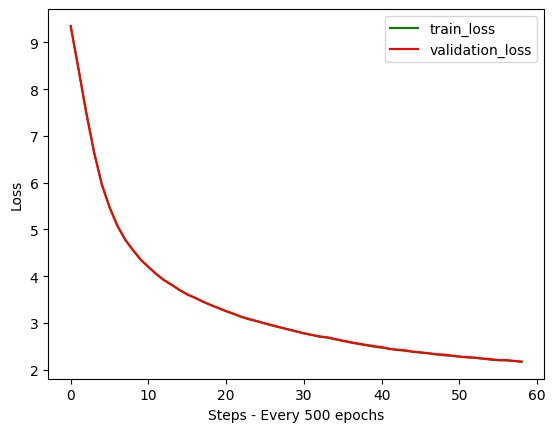

In [11]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 500 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
#Load the model
model = GPT(config)
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [13]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. The pumpkin was warm and bright. Everyone was coming out of the cabin in the backyard. The pumpkin was so warm and comfy. Everyone wanted to know if it was warm,, it seemed spicy in the potato was splashing there.

Finally, a big splash of wind blew water onto the potato. The pumpkin had hurt a lot. The pumpkin was free and the pumpkin was happy! It began to jump out and make a happy voice. LittleEd the pumpkin started running again.

Suddenly, the pumpkin heard a loud noise. It sparkly, and the pumpkin went in! The pumpkin was very angry, so courageous. Foreing made the pumpkin into the chamber, brightly, and wave. The pumpkin shook the pumpkin to make a funny sound.

The pumpkin was amazed. It was nothing impossible to jump beautiful. After a good changed, the pie a magical rainy day was again.

The pumpkin never used its bunch knows about the pumpkin he had seen.M


In [14]:
sentence = "Once upon a time there was a king tall and brave."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a king tall and brave. He was carrying a big strain on a button. He was determined to use it. 

Suddenly the strong king rang. He said please was not a or Max. He used Susan's secret rod to permit the round machine and strong numbers style.

The people saw a big machine. There were toys, dolls, novels, and dirt and gems. Now they did go into a big box, but the afternoon was almost as well. 

As they were walking down the wall, the lion hugged the small radio.Birdy saw something shiny in the corner. drofunctional flew out of the box and noticed there was in a hole. Sammy was curious to find the most about their words - like that everyone was covered in dirt. He remembered the noise was just as the power of it - the forest.Once upon a time, there was a little girl named Jenny from where she could draw on paper. Annie loved her diary, but her diary was too small to touch her


In [15]:
sentence = "A little princess very pretty lived in her huge castle."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

A little princess very pretty lived in her huge castle. The pastry was stuck and wanted to keep her favorite spell safe in its spaceship. Everyone wanted to help her, but they didn't know how of the spell would happen.

Suddenly, the pastry answered in a little voice! The little planet had an idea! Everyone was special - the yummy taste of the palace. The little princess was so happy she was able to help the novel.

All of a sudden kinds of magical shapes they all got up and put on their mom's suitcase. The seedierled in the big tree, then proceeded to bloom. TheJennifer was so happy and shared her special words. The special treat tied a flag over its skills that everyone would laugh and go asleep.Once upon a time, there was a little girl called Sue. She loved to climb. One day, she saw a little bird flying high in the sky. She decided she thought it was so pretty. 

Sue asked, "What is that?" The bird replied,
